# Deep Learning - Time Series Prediction

## Objective of this Notebook
- Show how to use LSTM for time series prediction with Keras
- Calculate confidence bands for predictions with LSTMs
- Do some simple feature engineering

In [1]:
# Plotting
%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt

# ignore warnings in this demo notebook
import warnings; 
warnings.simplefilter('ignore')

from datetime import datetime
import pandas as pd
import numpy as np

# Normalization
from sklearn.preprocessing import MinMaxScaler

# Deep Learing
import keras
import itertools
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.utils import to_categorical
from keras.optimizers import Adam 
from keras.callbacks import History, TerminateOnNaN, ReduceLROnPlateau, EarlyStopping
from keras.utils import np_utils
from keras import backend as K

# Custom functions
from python_code.data_preparation import create_tensors
from python_code.data_preparation import load_series

rcParams['figure.figsize'] = 15, 6

Using TensorFlow backend.


## Task Description

### Load Data

You may have to modify the data preparation file (*00_load_smart_meter_data.R*) when applying this code to your own data. In this example, we just have a look at one series, namely the series with id **MAC000002**. We have:

- Number of series: 1
- Date range: 2013-10-30 00:00:00 CET to 2014-02-27 23:00:00 CET (121 days)

In [2]:
#data_path = '../prepared_data/london_smart_meter/'
data_path = "https://raw.githubusercontent.com/anofox/m3_konferenz/master/prepared_data/london_smart_meter/"
file = 'smart_meters_london_cleaned_same_start_with_weather_example.csv'
params = {'column_sort': 'date_time'}

df = load_series(data_path, file, params)
df.index = df.index.tz_localize('UCT').tz_convert('Etc/GMT-1')

# Recurrent Neural Network

### Parameters

We will fit a model for one day ahead energy prediction by using todays energy consumption. This is a little bit an artificial scnenario, but it is easy to modify this code for other scenarios. We will use 90 days for training (10% for validation) and 30 days for prediction by a rolling window approach.

In [3]:
h_params = {'n_in': 24, 'n_out': 24, 'step_foreward': 24, 'column_value': 'energy'}
date_train =  datetime.strptime('2014-01-27 23:00:00', '%Y-%m-%d %H:%M:%S')

## Univariate Model

### Data Preparation

First, split dataset into train and tes series.

In [4]:
df_train = df[df.index <= date_train]
df_test = df[df.index > date_train]

### Normalization

RNNs need for training normalized features, else convergence will be slow. So, let us first normalize energy consumption attribute into range (0, 1). 

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))

# train the scaler on the training data
scaler.fit(df_train[[h_params['column_value']]])
df_train[[h_params['column_value']]] = scaler.transform(df_train[[h_params['column_value']]])
df_test[[h_params['column_value']]] = scaler.transform(df_test[[h_params['column_value']]])
df_train.describe()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,energy
count,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.00000,2160.000000,2160.000000
mean,11.020843,220.766204,7.453370,4.644431,1012.210560,5.587375,4.18312,0.828111,0.090101
std,3.019582,72.745156,2.793201,2.971788,14.695202,3.614686,2.34301,0.086937,0.118516
min,0.270000,0.000000,-1.270000,-3.300000,976.000000,-4.810000,0.11000,0.550000,0.000000
25%,9.975000,191.750000,5.547500,2.270000,1000.337500,3.037500,2.50000,0.770000,0.005903
50%,11.970000,223.000000,7.565000,4.560000,1012.695000,5.190000,3.80000,0.850000,0.052302
75%,12.730000,258.250000,9.315000,6.660000,1024.780000,7.702500,5.34000,0.890000,0.140024
max,16.090000,359.000000,15.080000,13.180000,1040.130000,15.080000,14.56000,1.000000,1.000000


###  Tensors

LSTMs need as input $X$ a tensor of rank 3. That is:

1. number of samples
2. number of input timestamps
3. number of features

![Full Series](./imgs/lstm.png)

([Image Source](https://deeplearning4j.org/usingrnns))

The LSTM output $Y$ is a tensor of rank 2. That is:

1. number of samples
2. number of output timestamps

In [6]:
train_X, train_y = create_tensors(df_train.drop('id', axis = 1), h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])
train_X.shape

(89, 24, 9)

### Define a Simple LSTM Model

Let us try a simple 3 layer LSTM network.  

In [7]:
def keras_model(dropout_rate):
    model = Sequential()
    model.add(Dropout(dropout_rate, input_shape=(train_X.shape[1], train_X.shape[2])))
    lstm = LSTM(256, recurrent_dropout=0.3)
    model.add(lstm)
    model.add(Dropout(dropout_rate))
    model.add(Dense(128))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128))
    model.add(Dense(h_params['n_out']))
    return model

In [8]:
model = keras_model(dropout_rate=0.2)
model.compile(loss='mae', optimizer=Adam())

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


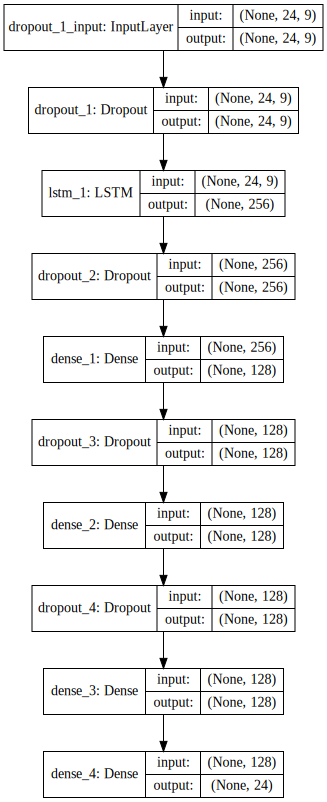

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Train LSTM Network

In [10]:
history = History()
nan_terminator = TerminateOnNaN()
early_stopping = EarlyStopping(patience=10, 
                               verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='loss', 
                              factor=0.5, 
                              patience=50, 
                              verbose=1, 
                              mode='auto', 
                              epsilon=0.0001, 
                              cooldown=0, 
                              min_lr=1e-8)

history = model.fit(train_X, train_y, epochs=250, batch_size=500, validation_split=0.1, verbose=1, shuffle=True,
                    callbacks=[history, nan_terminator, reduce_lr])

Train on 80 samples, validate on 9 samples
Epoch 1/250
80/80 [==============================] - 1s 15ms/step - loss: 0.8043 - val_loss: 0.3626
Epoch 2/250
80/80 [==============================] - 0s 505us/step - loss: 0.6671 - val_loss: 0.2445
Epoch 3/250
80/80 [==============================] - 0s 463us/step - loss: 0.6021 - val_loss: 0.2097
Epoch 4/250
80/80 [==============================] - 0s 563us/step - loss: 0.5560 - val_loss: 0.2179
Epoch 5/250
80/80 [==============================] - 0s 485us/step - loss: 0.5213 - val_loss: 0.2341
Epoch 6/250
80/80 [==============================] - 0s 553us/step - loss: 0.5057 - val_loss: 0.2316
Epoch 7/250
80/80 [==============================] - 0s 499us/step - loss: 0.4655 - val_loss: 0.2057
Epoch 8/250
80/80 [==============================] - 0s 648us/step - loss: 0.4242 - val_loss: 0.1902
Epoch 9/250
80/80 [==============================] - 0s 575us/step - loss: 0.4130 - val_loss: 0.1813
Epoch 10/250
80/80 [=============================

Epoch 81/250
80/80 [==============================] - 0s 530us/step - loss: 0.0922 - val_loss: 0.0649
Epoch 82/250
80/80 [==============================] - 0s 546us/step - loss: 0.0902 - val_loss: 0.0648
Epoch 83/250
80/80 [==============================] - 0s 492us/step - loss: 0.0892 - val_loss: 0.0647
Epoch 84/250
80/80 [==============================] - 0s 510us/step - loss: 0.0884 - val_loss: 0.0649
Epoch 85/250
80/80 [==============================] - 0s 526us/step - loss: 0.0886 - val_loss: 0.0652
Epoch 86/250
80/80 [==============================] - 0s 435us/step - loss: 0.0902 - val_loss: 0.0655
Epoch 87/250
80/80 [==============================] - 0s 515us/step - loss: 0.0895 - val_loss: 0.0658
Epoch 88/250
80/80 [==============================] - 0s 583us/step - loss: 0.0865 - val_loss: 0.0658
Epoch 89/250
80/80 [==============================] - 0s 578us/step - loss: 0.0881 - val_loss: 0.0656
Epoch 90/250
80/80 [==============================] - 0s 601us/step - loss: 0.0845

Epoch 161/250
80/80 [==============================] - 0s 581us/step - loss: 0.0609 - val_loss: 0.0633
Epoch 162/250
80/80 [==============================] - 0s 570us/step - loss: 0.0640 - val_loss: 0.0634
Epoch 163/250
80/80 [==============================] - 0s 559us/step - loss: 0.0612 - val_loss: 0.0635
Epoch 164/250
80/80 [==============================] - 0s 557us/step - loss: 0.0629 - val_loss: 0.0638
Epoch 165/250
80/80 [==============================] - 0s 508us/step - loss: 0.0615 - val_loss: 0.0640
Epoch 166/250
80/80 [==============================] - 0s 558us/step - loss: 0.0624 - val_loss: 0.0642
Epoch 167/250
80/80 [==============================] - 0s 523us/step - loss: 0.0608 - val_loss: 0.0644
Epoch 168/250
80/80 [==============================] - 0s 574us/step - loss: 0.0612 - val_loss: 0.0644
Epoch 169/250
80/80 [==============================] - 0s 507us/step - loss: 0.0609 - val_loss: 0.0645
Epoch 170/250
80/80 [==============================] - 0s 597us/step - lo

Epoch 241/250
80/80 [==============================] - 0s 560us/step - loss: 0.0560 - val_loss: 0.0636
Epoch 242/250
80/80 [==============================] - 0s 628us/step - loss: 0.0563 - val_loss: 0.0636
Epoch 243/250
80/80 [==============================] - 0s 1ms/step - loss: 0.0555 - val_loss: 0.0635
Epoch 244/250
80/80 [==============================] - 0s 799us/step - loss: 0.0564 - val_loss: 0.0633
Epoch 245/250
80/80 [==============================] - 0s 557us/step - loss: 0.0562 - val_loss: 0.0631
Epoch 246/250
80/80 [==============================] - 0s 654us/step - loss: 0.0573 - val_loss: 0.0627
Epoch 247/250
80/80 [==============================] - 0s 488us/step - loss: 0.0554 - val_loss: 0.0624
Epoch 248/250
80/80 [==============================] - 0s 633us/step - loss: 0.0560 - val_loss: 0.0623
Epoch 249/250
80/80 [==============================] - 0s 505us/step - loss: 0.0555 - val_loss: 0.0621
Epoch 250/250
80/80 [==============================] - 0s 510us/step - loss

### Evaluate Model

Summarize the training and validation loss

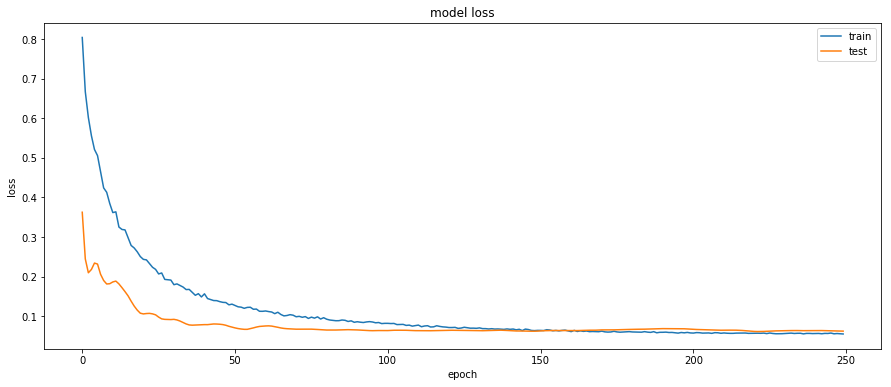

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Perform prediction

In [12]:
test_X, test_y = create_tensors(df_test.drop('id', axis = 1), h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])
prediction = model.predict(test_X)

In [13]:
yHat = scaler.inverse_transform(prediction).reshape(prediction.shape[0] * prediction.shape[1])
y = scaler.inverse_transform(test_y).reshape(prediction.shape[0] * prediction.shape[1])

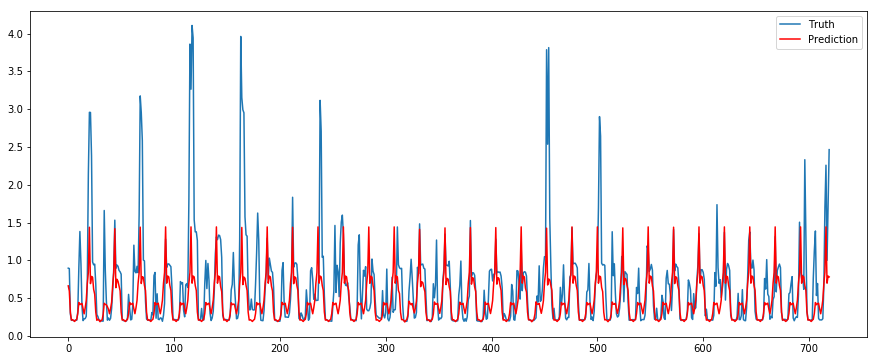

In [14]:
plt.plot(y)
plt.plot(yHat, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.show()

In [15]:
mape = np.mean(np.abs((yHat - y) / y )) * 100
smape = np.mean(np.abs((yHat - y) / (np.abs(y) + np.abs(yHat)) )) * 100
print("MAPE: %.2f SMAPE: %.2f" % (mape, smape))

MAPE: 34.38 SMAPE: 18.20


This can be done better. But let us next try to calculate confidence bands.

## Confidence Bands

In [16]:
def predict_with_uncertainty(model, test_X, n_iter=100):
    f = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
    all_pred = np.zeros((n_iter,) + (1, 24,))
    for iter in range(n_iter):
        all_pred[iter] = f([test_X, 1])
    ts_std = all_pred.std(axis = 0)
    avg_pred = all_pred.mean(axis=0)
    return all_pred, avg_pred, ts_std

Let us predict the first 10 days with confidence bands.

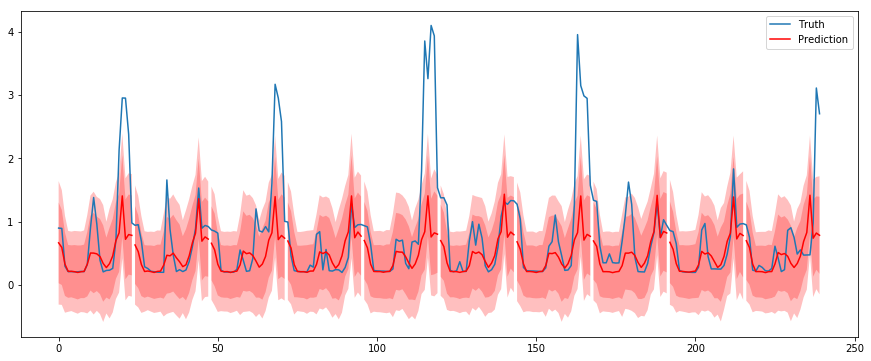

In [17]:
n = 10
plt.plot(y[:(n * 24)])
# n = len(test_X)
for i in range(0, n):
    _, avg_pred, ts_std = predict_with_uncertainty(model, test_X[i].reshape(1, 24, test_X[i].shape[1]), 100)
    yHat = scaler.inverse_transform(avg_pred).reshape(avg_pred.shape[0] * avg_pred.shape[1])
    YHat_SD = scaler.inverse_transform(ts_std).reshape(ts_std.shape[0] * ts_std.shape[1])
    y = scaler.inverse_transform(test_y).reshape(prediction.shape[0] * prediction.shape[1])
    plt.plot(range(i * 24, (i + 1) * 24), yHat, color='red')
    # plots the uncertainty to the degree of half a standard deviation
    plt.fill_between(range(i * 24, (i + 1) * 24),
                     yHat + 1.96 * YHat_SD, 
                     yHat - 1.96 * YHat_SD, 
                     facecolor='red', alpha=0.25)

    # plots the uncertainty to the degree of a full standard deviation
    plt.fill_between(range(i * 24, (i + 1) * 24),
                     yHat + 3 * YHat_SD, 
                     yHat - 3 * YHat_SD, 
                     facecolor='red', alpha=0.25)
    plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.show()

## Multivariate LSTM

In this section we add additional to the time related features some weather features. We **assume** in this experiment that the weather features in `X_test` are weather forecasts. This may be not practicable for longer prediction windows.

In [18]:
#data_path = '../prepared_data/london_smart_meter/'
data_path = "https://raw.githubusercontent.com/anofox/m3_konferenz/master/prepared_data/london_smart_meter/"
file = 'smart_meters_london_cleaned_same_start_with_weather_example.csv'
params = {'column_sort': 'date_time'}

df = load_series(data_path, file, params)
df.index = df.index.tz_localize('UCT').tz_convert('Etc/GMT-1')

In [19]:
h_params = {'n_in': 24, 'n_out': 24, 'step_foreward': 24, 'column_value': 'energy'}
date_train =  datetime.strptime('2014-01-27 23:00:00', '%Y-%m-%d %H:%M:%S')
df_train = df[df.index <= date_train].drop('id', axis = 1)
df_test = df[df.index > date_train].drop('id', axis = 1)
df_train.head()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,energy
date,,,,,,,,,
2013-10-30 00:00:00+01:00,14.31,244,6.86,4.61,1017.98,4.55,3.29,0.86,0.457
2013-10-30 01:00:00+01:00,14.31,238,6.10,4.09,1018.38,3.86,2.95,0.87,0.414
2013-10-30 02:00:00+01:00,13.45,247,5.94,4.17,1018.89,3.54,3.14,0.88,0.408
2013-10-30 03:00:00+01:00,13.23,249,5.54,3.92,1019.25,3.13,3.02,0.89,0.352
2013-10-30 04:00:00+01:00,14.31,242,5.06,3.28,1019.57,2.78,2.74,0.88,0.250


In [20]:
df_train['weekday'] = df_train.index.weekday
df_train['hour'] = df_train.index.hour
df_test['weekday'] = df_test.index.weekday
df_test['hour'] = df_test.index.hour

In [21]:
features = ['hour', 'weekday', 'visibility', 'windBearing', 'temperature', 'dewPoint', 
            'pressure', 'apparentTemperature', 'windSpeed', 'humidity']
for f in features:
    scaler_features = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(df_train[[f]])
    df_train[[f]] = scaler.transform(df_train[[f]])
    df_test[[f]] = scaler.transform(df_test[[f]])
    
scaler = MinMaxScaler(feature_range=(0, 1))
# train the scaler on the training data
scaler.fit(df_train[[h_params['column_value']]])
df_train[[h_params['column_value']]] = scaler.transform(df_train[[h_params['column_value']]])
df_test[[h_params['column_value']]] = scaler.transform(df_test[[h_params['column_value']]])

In [22]:
df_train.describe()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,energy,weekday,hour
count,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000
mean,0.679573,0.614948,0.533539,0.482065,0.564643,0.522744,0.281877,0.618025,0.090101,0.503704,0.500000
std,0.190871,0.202633,0.170838,0.180327,0.229147,0.181734,0.162146,0.193193,0.118516,0.333390,0.301034
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.613464,0.534123,0.416972,0.337985,0.379503,0.394545,0.165398,0.488889,0.005903,0.166667,0.250000
50%,0.739570,0.621170,0.540367,0.476942,0.572197,0.502765,0.255363,0.666667,0.052302,0.500000,0.500000
75%,0.787611,0.719359,0.647401,0.604369,0.760642,0.629085,0.361938,0.755556,0.140024,0.833333,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
train_X, train_y = create_tensors(df_train, h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])

In [24]:
model = keras_model(dropout_rate=0.2)
model.compile(loss='mae', optimizer=Adam())

history = History()
nan_terminator = TerminateOnNaN()
early_stopping = EarlyStopping(patience=10, 
                               verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='loss', 
                              factor=0.5, 
                              patience=50, 
                              verbose=1, 
                              mode='auto', 
                              epsilon=0.0001, 
                              cooldown=0, 
                              min_lr=1e-8)

history = model.fit(train_X, train_y, epochs=250, batch_size=500, validation_split=0.1, verbose=1, shuffle=True,
                    callbacks=[history, nan_terminator, reduce_lr])

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.
Train on 80 samples, validate on 9 samples
Epoch 1/250
80/80 [==============================] - 1s 7ms/step - loss: 0.1641 - val_loss: 0.1067
Epoch 2/250
80/80 [==============================] - 0s 551us/step - loss: 0.1284 - val_loss: 0.0890
Epoch 3/250
80/80 [==============================] - 0s 495us/step - loss: 0.1106 - val_loss: 0.0813
Epoch 4/250
80/80 [==============================] - 0s 544us/step - loss: 0.1006 - val_loss: 0.0776
Epoch 5/250
80/80 [==============================] - 0s 497us/step - loss: 0.0932 - val_loss: 0.0756
Epoch 6/250
80/80 [==============================] - 0s 686us/step - loss: 0.0880 - val_loss: 0.0735
Epoch 7/250
80/80 [==============================] - 0s 636us/step - loss: 0.0868 - val_loss: 0.0713
Epoch 8/250
80/80 [==============================] - 0s 548us/step - loss: 0.0838 - val_loss: 0.0703
Epoch 9/250
80

Epoch 80/250
80/80 [==============================] - 0s 581us/step - loss: 0.0515 - val_loss: 0.0566
Epoch 81/250
80/80 [==============================] - 0s 506us/step - loss: 0.0518 - val_loss: 0.0575
Epoch 82/250
80/80 [==============================] - 0s 502us/step - loss: 0.0509 - val_loss: 0.0575
Epoch 83/250
80/80 [==============================] - 0s 495us/step - loss: 0.0508 - val_loss: 0.0568
Epoch 84/250
80/80 [==============================] - 0s 545us/step - loss: 0.0519 - val_loss: 0.0556
Epoch 85/250
80/80 [==============================] - 0s 567us/step - loss: 0.0508 - val_loss: 0.0551
Epoch 86/250
80/80 [==============================] - 0s 636us/step - loss: 0.0504 - val_loss: 0.0553
Epoch 87/250
80/80 [==============================] - 0s 563us/step - loss: 0.0521 - val_loss: 0.0562
Epoch 88/250
80/80 [==============================] - 0s 431us/step - loss: 0.0511 - val_loss: 0.0571
Epoch 89/250
80/80 [==============================] - 0s 573us/step - loss: 0.0515

Epoch 160/250
80/80 [==============================] - 0s 524us/step - loss: 0.0486 - val_loss: 0.0578
Epoch 161/250
80/80 [==============================] - 0s 555us/step - loss: 0.0482 - val_loss: 0.0584
Epoch 162/250
80/80 [==============================] - 0s 567us/step - loss: 0.0493 - val_loss: 0.0576
Epoch 163/250
80/80 [==============================] - 0s 490us/step - loss: 0.0496 - val_loss: 0.0568
Epoch 164/250
80/80 [==============================] - 0s 567us/step - loss: 0.0494 - val_loss: 0.0556
Epoch 165/250
80/80 [==============================] - 0s 583us/step - loss: 0.0484 - val_loss: 0.0555
Epoch 166/250
80/80 [==============================] - 0s 483us/step - loss: 0.0487 - val_loss: 0.0564
Epoch 167/250
80/80 [==============================] - 0s 505us/step - loss: 0.0480 - val_loss: 0.0571
Epoch 168/250
80/80 [==============================] - 0s 489us/step - loss: 0.0486 - val_loss: 0.0575
Epoch 169/250
80/80 [==============================] - 0s 491us/step - lo

Epoch 240/250
80/80 [==============================] - 0s 576us/step - loss: 0.0463 - val_loss: 0.0561
Epoch 241/250
80/80 [==============================] - 0s 554us/step - loss: 0.0464 - val_loss: 0.0555
Epoch 242/250
80/80 [==============================] - 0s 540us/step - loss: 0.0466 - val_loss: 0.0563
Epoch 243/250
80/80 [==============================] - 0s 560us/step - loss: 0.0465 - val_loss: 0.0570
Epoch 244/250
80/80 [==============================] - 0s 470us/step - loss: 0.0476 - val_loss: 0.0562
Epoch 245/250
80/80 [==============================] - 0s 587us/step - loss: 0.0469 - val_loss: 0.0557
Epoch 246/250
80/80 [==============================] - 0s 554us/step - loss: 0.0458 - val_loss: 0.0553
Epoch 247/250
80/80 [==============================] - 0s 515us/step - loss: 0.0458 - val_loss: 0.0553
Epoch 248/250
80/80 [==============================] - 0s 594us/step - loss: 0.0462 - val_loss: 0.0551
Epoch 249/250
80/80 [==============================] - 0s 543us/step - lo

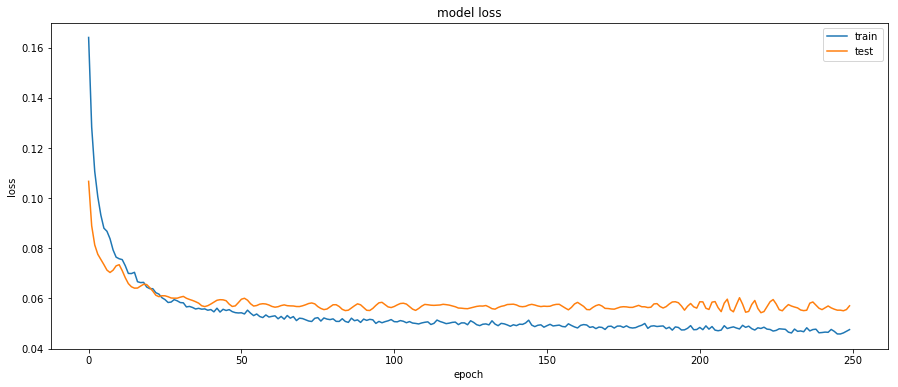

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [26]:
test_X, test_y = create_tensors(df_test, h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])
prediction = model.predict(test_X)

In [27]:
yHat = scaler.inverse_transform(prediction).reshape(prediction.shape[0] * prediction.shape[1])
y = scaler.inverse_transform(test_y).reshape(prediction.shape[0] * prediction.shape[1])

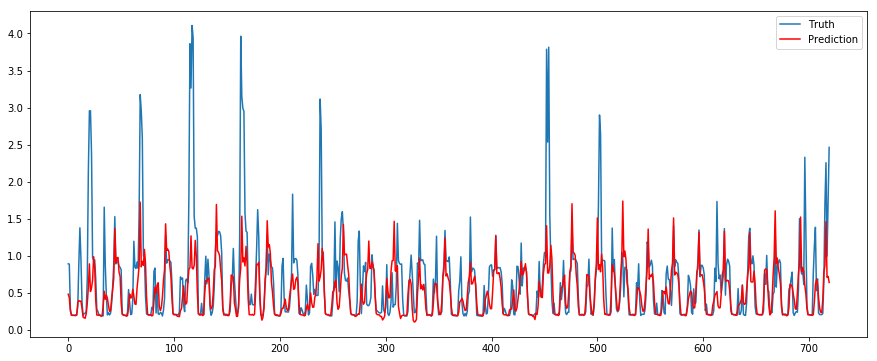

In [28]:
plt.plot(y)
plt.plot(yHat, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.show()

In [29]:
mape = np.mean(np.abs((yHat - y) / y )) * 100
smape = np.mean(np.abs((yHat - y) / (np.abs(y) + np.abs(yHat)) )) * 100
print("MAPE: %.2f SMAPE: %.2f" % (mape, smape))

MAPE: 32.69 SMAPE: 16.87


We got an improvement on about **2%** for this series by using additional features.